# HW 10 CLUSTERING BUSINESS

# cluster time trends in NYC businesses: 
# DATA
# Census Business data:
## download census data for businesses by ZIP code. the data is here
http://www.census.gov/econ/cbp/download/
##  you can  download it with 3 terminal commands as follows: the data from 1993 through 2001 is different in the format of its path than the data after 2001 (that is why more than one for loop is needed)



NOTES: 
to read in a zip file without unzipping it you can use the pandas and zipfile packages

In [1]:
import pandas as pd
import geopandas as  gpd
import os
import zipfile #i am not giving it a name cause i intend to use it only once
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist, pdist
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster
from sklearn.cluster import AgglomerativeClustering
from matplotlib import cm
import matplotlib.pyplot as plt

%matplotlib inline

## 1.get and prepare data
Geojason data is in my folder PUIdata/Census Business data, called 'nyc-zip-code-tabulation-areas-polygons.geojson'

Census data is in my folder PUIdata/Census Business data, called 'zbpXXtotals.zip' (XX = 94 ~ 15)



In [2]:
path = os.getenv("PUIDATA")+ '/Census Business data/'
path

'/home/cusp/cc5219/PUIdata/Census Business data/'

#### (1)GEO data

In [3]:
geonyc = gpd.read_file(path + "nyc-zip-code-tabulation-areas-polygons.geojson")

In [4]:
geonyc.head()

,@id,BLDGpostalCode,CTY_FIPS,OBJECTID,PO_NAME,STATE,ST_FIPS,Shape_Area,Shape_Leng,borough,geometry,postalCode
0,http://nyc.pediacities.com/Resource/PostalCode...,0,081,1,Jackson Heights,NY,36,2.016328e+07,20624.692317,Queens,POLYGON ((-73.86942457284175 40.74915687096787...,11372
1,http://nyc.pediacities.com/Resource/PostalCode...,0,081,2,Glen Oaks,NY,36,2.260653e+07,23002.816039,Queens,POLYGON ((-73.71068374074007 40.75004039450917...,11004
2,http://nyc.pediacities.com/Resource/PostalCode...,0,081,3,New Hyde Park,NY,36,6.269333e+06,15749.161511,Queens,POLYGON ((-73.70098278625547 40.73889569923034...,11040
3,http://nyc.pediacities.com/Resource/PostalCode...,0,081,4,Bellerose,NY,36,4.941836e+07,35932.810639,Queens,POLYGON ((-73.72270447144122 40.75373371438336...,11426
4,http://nyc.pediacities.com/Resource/PostalCode...,0,081,5,Fresh Meadows,NY,36,6.938587e+07,38693.565676,Queens,POLYGON ((-73.81088634744755 40.72717187575918...,11365


In [5]:
geonyc.shape

(262, 12)

In [6]:
#change colum name and delet what we dont need
geonyc = geonyc.rename(columns={'postalCode': "ZIP"})
geonyc = geonyc.loc[:,['ZIP', 'geometry','borough', 'PO_NAME']]

In [7]:
geonyc['ZIP'] = pd.to_numeric(geonyc.ZIP).values

In [8]:
geonyc.head()

,ZIP,geometry,borough,PO_NAME
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,Queens,Jackson Heights
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,Queens,Glen Oaks
2,11040,POLYGON ((-73.70098278625547 40.73889569923034...,Queens,New Hyde Park
3,11426,POLYGON ((-73.72270447144122 40.75373371438336...,Queens,Bellerose
4,11365,POLYGON ((-73.81088634744755 40.72717187575918...,Queens,Fresh Meadows


In [9]:
geonyc.shape

(262, 4)

#### (2) CBD data

In [10]:
cbd = pd.DataFrame()
for yr in range(1994,2015):
    year = str(yr)[2:4]
    fname = 'zbp' + year + 'totals.zip'
    zf = zipfile.ZipFile(path + fname)
    df = pd.read_csv(zf.open(fname.replace('.zip','.txt')))
    df.columns = [item.upper() for item in df.columns] 
    df['YEAR'] = yr
    temp = df.loc[:,['ZIP','YEAR','EST']]
    cbd = pd.concat([cbd, temp], axis=0)

In [11]:
cbd.head()

,ZIP,YEAR,EST
0,1001,1994,439
1,1002,1994,450
2,1003,1994,10
3,1004,1994,47
4,1005,1994,92


In [12]:
cbd.shape

(828791, 3)

In [13]:
cbd.YEAR.unique()

array([1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])

## 2. merge data

#### First merge CBD data and GEO data to get information of year/est VS geometry

In [14]:
cbd = cbd.merge(geonyc, on='ZIP')
print cbd.shape
cbd.head()

(5302, 6)


,ZIP,YEAR,EST,geometry,borough,PO_NAME
0,10001,1994,6999,POLYGON ((-74.00827017711134 40.75258714368449...,Manhattan,New York
1,10001,1995,7088,POLYGON ((-74.00827017711134 40.75258714368449...,Manhattan,New York
2,10001,1996,7075,POLYGON ((-74.00827017711134 40.75258714368449...,Manhattan,New York
3,10001,1997,7154,POLYGON ((-74.00827017711134 40.75258714368449...,Manhattan,New York
4,10001,1998,7254,POLYGON ((-74.00827017711134 40.75258714368449...,Manhattan,New York


#### Then drop data in CBD with Zipcodes which are not in GEO data

In [15]:
cbd_dropzip = cbd[cbd["ZIP"].isin(geonyc['ZIP'].astype(int))]
cbd_dropzip  = cbd_dropzip .dropna()
cbd_dropzip .head()

,ZIP,YEAR,EST,geometry,borough,PO_NAME
0,10001,1994,6999,POLYGON ((-74.00827017711134 40.75258714368449...,Manhattan,New York
1,10001,1995,7088,POLYGON ((-74.00827017711134 40.75258714368449...,Manhattan,New York
2,10001,1996,7075,POLYGON ((-74.00827017711134 40.75258714368449...,Manhattan,New York
3,10001,1997,7154,POLYGON ((-74.00827017711134 40.75258714368449...,Manhattan,New York
4,10001,1998,7254,POLYGON ((-74.00827017711134 40.75258714368449...,Manhattan,New York


In [16]:
cbd_dropzip .shape

(5302, 6)

## 3. Pivot 

pivot cbd_dropzip: ZIP as index, YEAR as columns, and EST as values

In [17]:
# ZIP as index, YEAR as columns, and EST as values
cbd_pivot = cbd_dropzip .pivot_table(index='ZIP', columns='YEAR', values='EST')
cbd_pivot.head()

YEAR,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIP,,,,,,,,,,,,,,,,,,,,,
10001,6999.0,7088.0,7075.0,7154.0,7254.0,7233.0,7317.0,7188.0,7141.0,7084.0,...,7312.0,7415.0,7549.0,7472.0,7305.0,7241.0,7227.0,7235.0,7273.0,7369.0
10002,1784.0,1819.0,1919.0,2049.0,2003.0,2085.0,2277.0,2543.0,2269.0,2402.0,...,2682.0,2686.0,2685.0,2691.0,2775.0,2872.0,2912.0,2954.0,2988.0,2972.0
10003,3256.0,3377.0,3417.0,3535.0,3649.0,3659.0,3683.0,3602.0,3616.0,3704.0,...,3867.0,3909.0,4049.0,4071.0,4099.0,4113.0,4159.0,4214.0,4277.0,4333.0
10004,1115.0,1124.0,1133.0,1173.0,1176.0,1233.0,1294.0,1247.0,1253.0,1252.0,...,1260.0,1311.0,1370.0,1376.0,1379.0,1398.0,1404.0,1442.0,1479.0,1554.0
10005,1076.0,1109.0,1216.0,1227.0,1270.0,1242.0,1287.0,1249.0,1244.0,1200.0,...,1214.0,1259.0,1273.0,1291.0,1274.0,1266.0,1301.0,1273.0,1296.0,1321.0


In [18]:
cbd_pivot.shape

(244, 21)

## 4. White data

In [19]:
cbd_standardized = cbd_pivot.dropna().copy()
for row in cbd_standardized.index:
    row_values = cbd_pivot.ix[row]
    row_mean = row_values.mean()
    row_std = row_values.std()
    cbd_standardized.ix[row] = (row_values - row_mean)/row_std

In [20]:
cbd_standardized.head()

YEAR,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
ZIP,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.432324,1.179819,2.152288,1.593481,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.522100,0.532058,0.529569,0.544506,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.127855,0.261785,0.708216,0.778369,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,-0.313478,0.108300,0.596238,0.645859,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,-0.496872,0.260457,0.496070,0.799002,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888


In [21]:
cbd_standardized.shape

(230, 21)

### check if cbd_standardized meets the following requirements

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))

In [22]:
cbd_standardized.T.describe()

ZIP,10001,10002,10003,10004,10005,10006,10007,10009,10010,10011,...,11433,11434,11435,11436,11451,11691,11692,11693,11694,11697
count,2.100000e+01,2.100000e+01,2.100000e+01,2.100000e+01,2.100000e+01,2.100000e+01,2.100000e+01,2.100000e+01,2.100000e+01,2.100000e+01,...,2.100000e+01,2.100000e+01,2.100000e+01,2.100000e+01,2.100000e+01,2.100000e+01,2.100000e+01,2.100000e+01,2.100000e+01,2.100000e+01
mean,-9.251859e-16,2.220446e-16,-5.286776e-17,-1.691768e-16,-1.776357e-15,1.057355e-17,-5.498247e-16,1.586033e-16,2.960595e-16,-1.173664e-15,...,8.247371e-16,-6.449867e-16,8.458842e-17,-3.595008e-16,-4.229421e-17,-2.220446e-16,-2.854859e-16,-3.383537e-16,-1.586033e-16,-8.591012e-17
std,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00
min,-1.839191e+00,-1.713540e+00,-1.820497e+00,-1.512649e+00,-2.819347e+00,-1.085548e+00,-1.056204e+00,-1.700614e+00,-1.696628e+00,-2.146355e+00,...,-2.114934e+00,-1.632651e+00,-1.405005e+00,-1.347340e+00,-1.134733e+00,-1.384773e+00,-1.502558e+00,-1.264937e+00,-1.434758e+00,-1.716434e+00
25%,-7.143192e-01,-9.641777e-01,-6.725316e-01,-5.367717e-01,-2.949174e-01,-8.113041e-01,-6.344312e-01,-7.778423e-01,-5.891975e-01,-5.554644e-01,...,-4.937241e-01,-7.928215e-01,-9.302327e-01,-9.885376e-01,-1.134733e+00,-8.514033e-01,-6.697621e-01,-7.608826e-01,-8.428148e-01,-6.665764e-01
50%,-8.293983e-02,1.959653e-01,-1.623247e-01,-1.232645e-01,2.604570e-01,-6.056213e-01,-4.111398e-01,1.827043e-01,-4.231805e-02,1.385483e-01,...,2.603272e-01,-2.666125e-02,-4.710039e-04,1.903850e-01,-2.182179e-01,6.625707e-03,-2.996304e-01,-3.576388e-01,-3.100656e-01,-1.416475e-01
75%,4.686100e-01,7.536306e-01,8.676553e-01,6.706693e-01,5.128999e-01,9.027186e-01,3.248949e-01,6.359959e-01,6.822972e-01,7.364670e-01,...,5.242452e-01,7.837005e-01,7.314691e-01,8.054751e-01,6.982972e-01,5.863750e-01,6.256988e-01,1.154525e+00,1.051404e+00,1.083187e+00
max,2.152288e+00,1.283911e+00,1.613833e+00,2.117945e+00,1.303888e+00,1.645462e+00,2.268357e+00,1.618128e+00,1.926448e+00,1.361079e+00,...,1.617620e+00,1.667732e+00,1.690904e+00,1.676853e+00,1.614812e+00,1.861824e+00,1.828627e+00,1.406553e+00,1.406571e+00,1.608116e+00


#### - -cbd_standardized meets the requirements

## 5.Clustering

Choose number of clusters by elbow

In [23]:
def elbow(data, K):
    '''This function is to calculate average within-cluster
    sum of squares, and plot the "elbow"
    data: dataframe of features,
    K: list of selected number of cluster'''
    
    KM = [KMeans(n_clusters=k).fit(data) for k in K]
    centroids = [k.cluster_centers_ for k in KM]
    
    D_k = [cdist(data, cent, 'euclidean') for cent in centroids]
    globals()['dist'] = [np.min(D, axis=1) for D in D_k]
    avgWithinSS = [sum(d)/data.shape[0] for d in dist]
    
    # elbow curve
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.plot(K, avgWithinSS, 'b*-')
    plt.grid(True)
    plt.xlabel('Number of clusters')
    plt.ylabel('Average within-cluster sum of squares')
    plt.title('Elbow for KMeans clustering')
    plt.show()

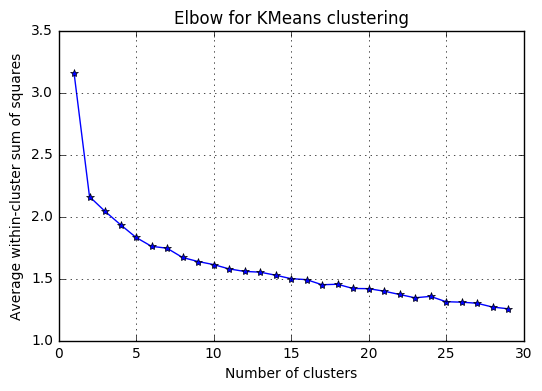

In [24]:
elbow(cbd_standardized, range(1,30))

#### From the plot elbow shows number of clusters should be 2.

But 'a few is more than a couple'. so I am going to try k=3 and 5

## 6. Plot




### (1)Use K-means

In [25]:
k1 = 3
k2 = 5

#### a) k = 3

In [27]:
KMS = KMeans(n_clusters=k1).fit(cbd_standardized)
len(KMS.labels_)

230

(1994, 2014)

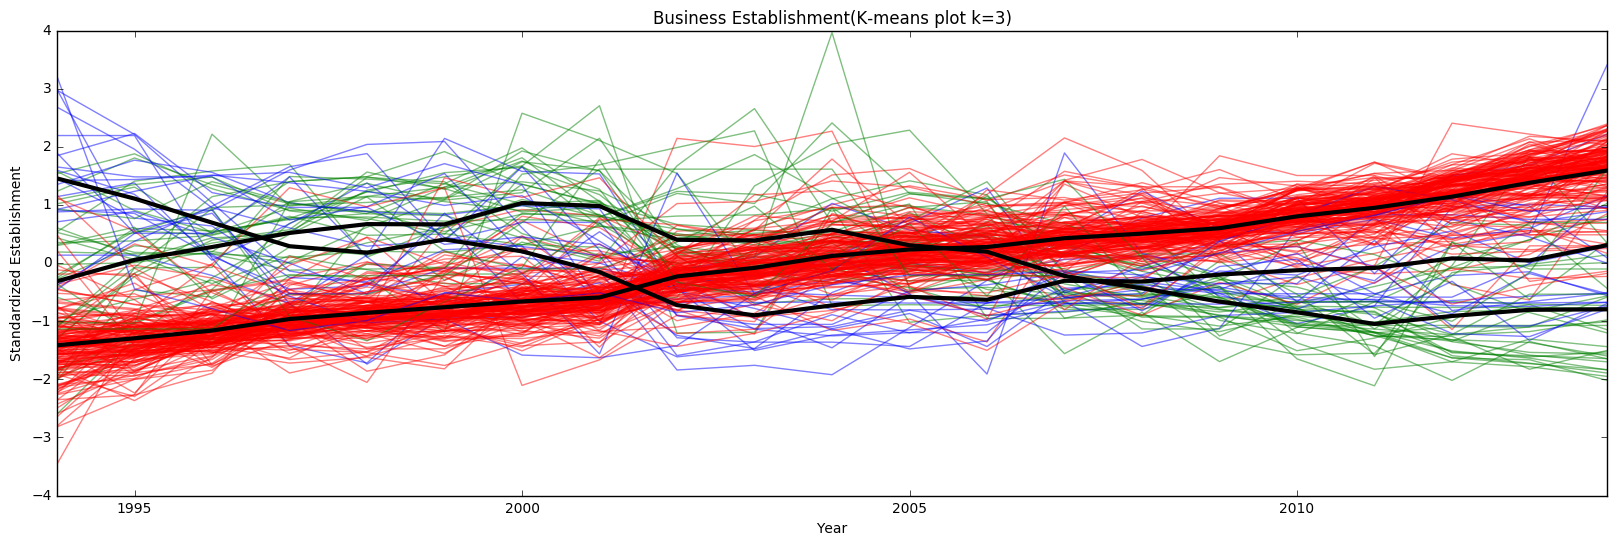

In [28]:
fig = plt.figure()
color = ['r','g','b','m','y']
plt.figure(figsize=(20,6))
for i in range(len(cbd_standardized)):
     c = KMS.labels_[i]
     plt.plot(range(1994,2015), cbd_standardized.iloc[i,:21],c=color[c],alpha=0.5)
for i in range(len(KMS.cluster_centers_)):
    plt.plot(range(1994,2015), KMS.cluster_centers_[i], color="black", linewidth=3)
plt.title("Business Establishment(K-means plot k=3)")
plt.ylabel("Standardized Establishment")
plt.xlabel("Year")
plt.xlim(1994,2014)

#### Fig 1 K-Means when k=3

#### b) k=5

In [29]:
KMS2 = KMeans(n_clusters=k2).fit(cbd_standardized)
len(KMS2.labels_)

230

(1994, 2014)

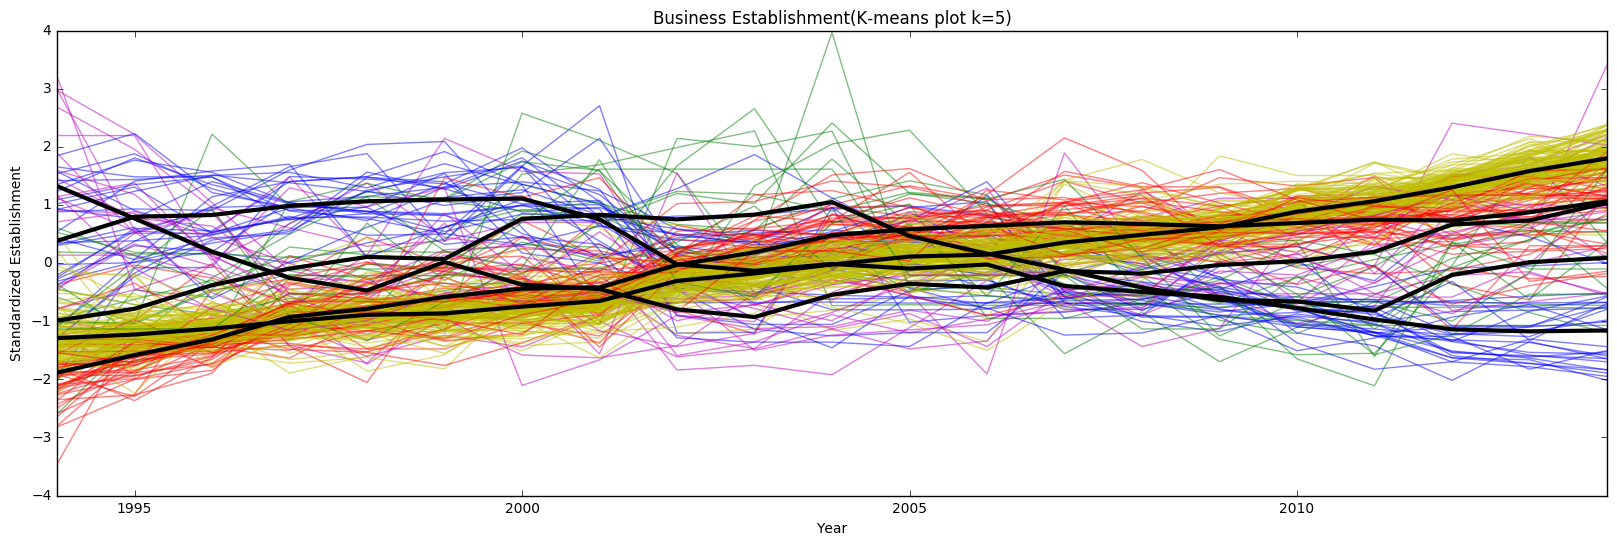

In [30]:
fig = plt.figure()
color = ['r','g','b','m','y']
plt.figure(figsize=(20,6))
for i in range(len(cbd_standardized)):
     c = KMS2.labels_[i]
     plt.plot(range(1994,2015), cbd_standardized.iloc[i,:21],c=color[c],alpha=0.5)
for i in range(len(KMS2.cluster_centers_)):
    plt.plot(range(1994,2015), KMS2.cluster_centers_[i], color="black", linewidth=3)
plt.title("Business Establishment(K-means plot k=5)")
plt.ylabel("Standardized Establishment")
plt.xlabel("Year")
plt.xlim(1994,2014)

#### Fig 1 K-Means when k=5

### (2) Use Hierarchical Clustering Dendrogram 

In [31]:
HCD = linkage(cbd_standardized.iloc[:,:21].values, 'ward')

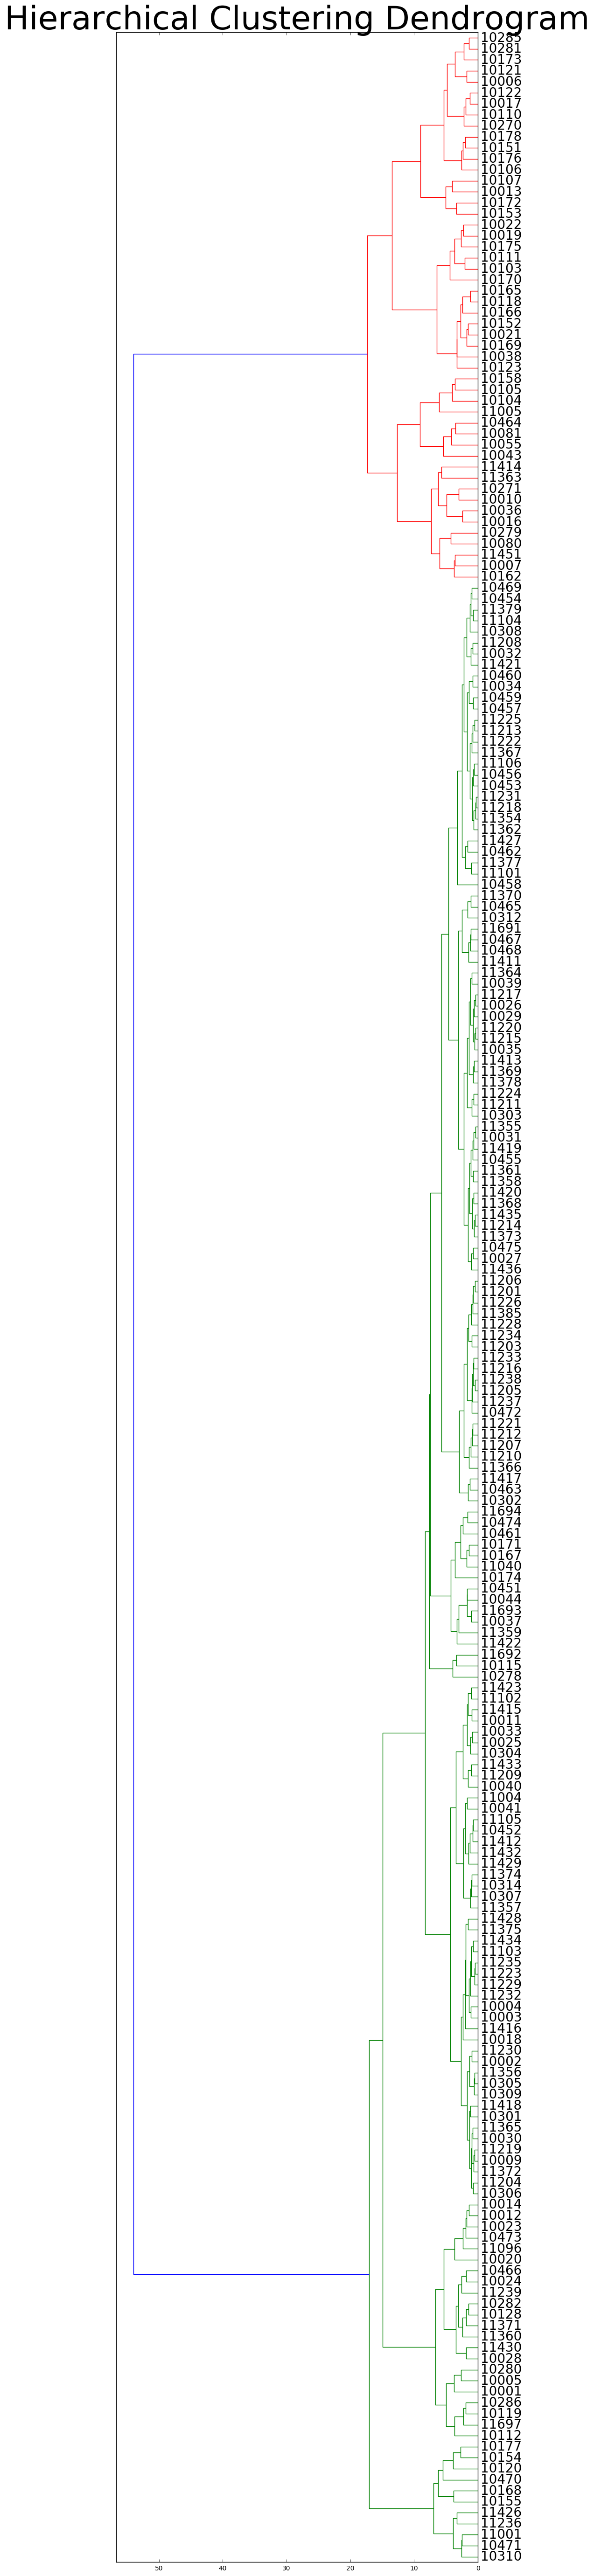

In [32]:
plt.figure(figsize=(10, 70))
plt.title('Hierarchical Clustering Dendrogram', fontsize=50)
dendrogram(
    HCD,
    orientation="left",
    labels = cbd_standardized.iloc[:,:21].index.values,
    leaf_font_size=20.,  # font size for the x axis labels
)
plt.show()

## 6.overlay data on a NYC map

In [33]:
cbd_standardized.shape

(230, 21)

In [34]:

cbd2 = cbd_standardized.copy()
cbd2['KM_3'] = KMS.labels_
cbd2['KM_5'] = KMS2.labels_
# CB2['DBSCAN'] = mod_DBSCAN.labels_
# cbd2['HCD'] = HCD
cbd2['HCD_3'] = fcluster(HCD, k1, criterion='maxclust')
cbd2['HCD_5'] = fcluster(HCD, k2, criterion='maxclust')
# CB2['HC_'] = CB2.HC.replace([1,4],[4,1])
#zipdf = zipcode.merge(KMdf, on="zip").merge(ACdf, on="zip")


In [35]:
cbd2.head()

YEAR,1994,1995,1996,1997,1998,1999,2000,2001,2002,2003,...,2009,2010,2011,2012,2013,2014,KM_3,KM_5,HCD_3,HCD_5
ZIP,,,,,,,,,,,,,,,,,,,,,
10001,-1.839191,-1.193297,-1.287641,-0.714319,0.011404,-0.140998,0.468610,-0.467573,-0.808663,-1.222326,...,0.381523,-0.082940,-0.184541,-0.126483,0.149292,0.845986,0,0,1,2
10002,-1.713540,-1.626405,-1.377447,-1.053802,-1.168323,-0.964178,-0.486179,0.176049,-0.506095,-0.174982,...,0.753631,0.995120,1.094703,1.199265,1.283911,1.244077,0,0,1,3
10003,-1.820497,-1.434653,-1.307101,-0.930824,-0.567301,-0.535414,-0.458882,-0.717175,-0.672532,-0.391918,...,0.867655,0.912298,1.058983,1.234367,1.435260,1.613833,0,4,1,3
10004,-1.512649,-1.438217,-1.363786,-1.032980,-1.008170,-0.536772,-0.032293,-0.420990,-0.371369,-0.379639,...,0.670669,0.827802,0.877423,1.191688,1.497684,2.117945,0,4,1,3
10005,-2.819347,-2.263972,-0.463213,-0.278088,0.445582,-0.025645,0.731684,0.092162,0.008014,-0.732485,...,0.512900,0.378264,0.967297,0.496070,0.883150,1.303888,0,0,1,2


In [36]:
df_labels1 = pd.DataFrame(cbd2['KM_3']).reset_index()
geonyc = pd.merge(geonyc,df_labels1, how='left', on='ZIP')
df_labels2 = pd.DataFrame(cbd2['KM_5']).reset_index()
geonyc = pd.merge(geonyc,df_labels2, how='left', on='ZIP')
geonyc.fillna(-1, inplace=True) # because first cluster start from 0
geonyc.head()

,ZIP,geometry,borough,PO_NAME,KM_3,KM_5
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,Queens,Jackson Heights,0.0,4.0
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,Queens,Glen Oaks,0.0,0.0
2,11040,POLYGON ((-73.70098278625547 40.73889569923034...,Queens,New Hyde Park,0.0,4.0
3,11426,POLYGON ((-73.72270447144122 40.75373371438336...,Queens,Bellerose,2.0,3.0
4,11365,POLYGON ((-73.81088634744755 40.72717187575918...,Queens,Fresh Meadows,0.0,4.0


In [37]:
df_labels3 = pd.DataFrame(cbd2['HCD_3']).reset_index()
geonyc = pd.merge(geonyc,df_labels3, how='left', on='ZIP')
df_labels4 = pd.DataFrame(cbd2['HCD_5']).reset_index()
geonyc = pd.merge(geonyc,df_labels4, how='left', on='ZIP')
geonyc.fillna(-1, inplace=True) # because first cluster start from 0
geonyc.head()

,ZIP,geometry,borough,PO_NAME,KM_3,KM_5,HCD_3,HCD_5
0,11372,POLYGON ((-73.86942457284175 40.74915687096787...,Queens,Jackson Heights,0.0,4.0,1.0,3.0
1,11004,POLYGON ((-73.71068374074007 40.75004039450917...,Queens,Glen Oaks,0.0,0.0,1.0,3.0
2,11040,POLYGON ((-73.70098278625547 40.73889569923034...,Queens,New Hyde Park,0.0,4.0,1.0,3.0
3,11426,POLYGON ((-73.72270447144122 40.75373371438336...,Queens,Bellerose,2.0,3.0,1.0,1.0
4,11365,POLYGON ((-73.81088634744755 40.72717187575918...,Queens,Fresh Meadows,0.0,4.0,1.0,3.0


####  plots for k=3

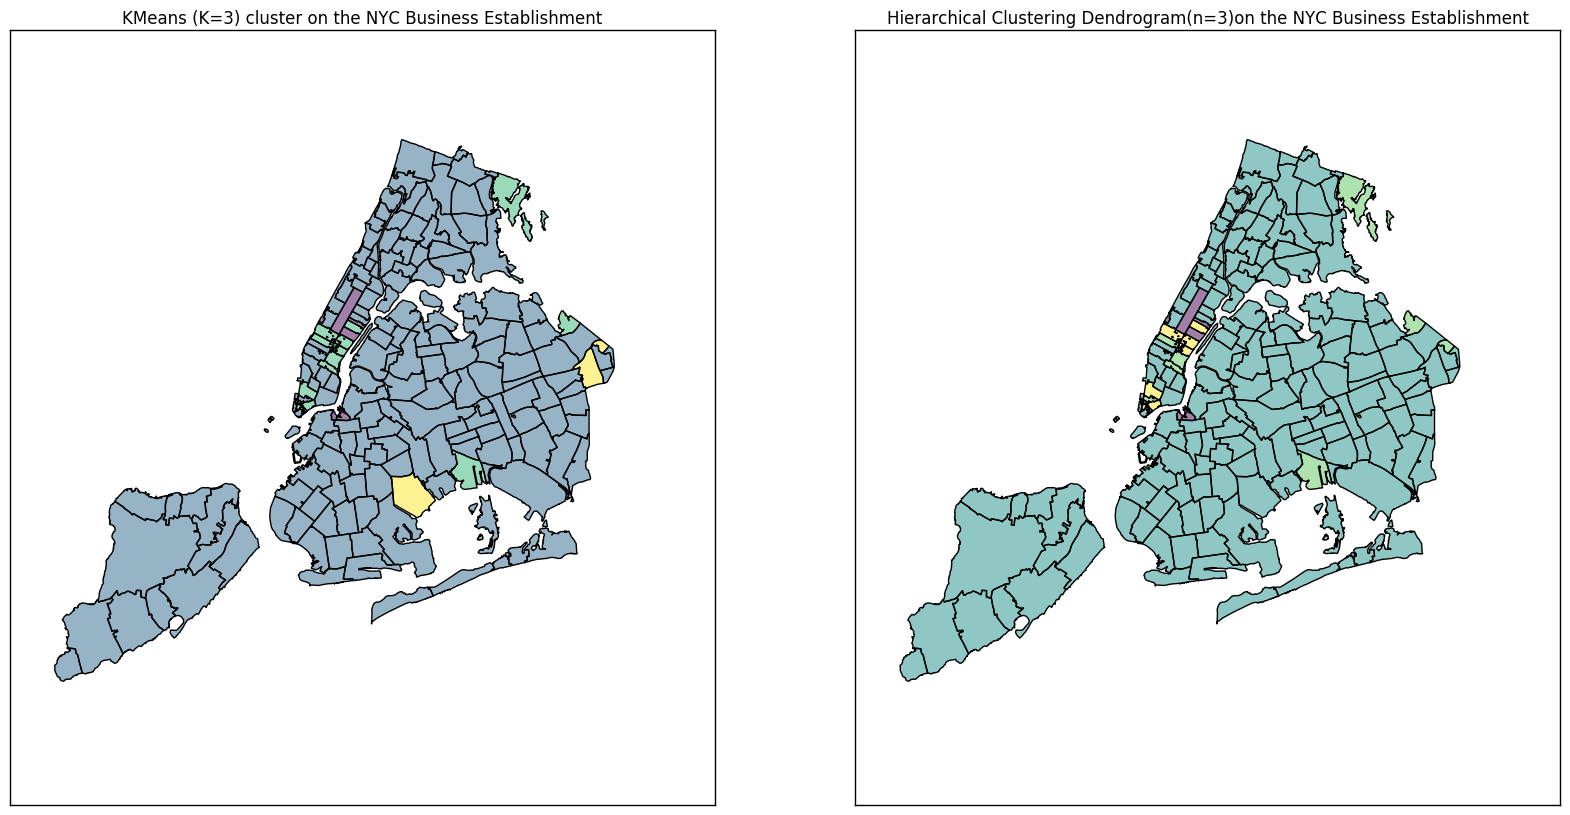

In [47]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
geonyc.plot(column="KM_3", cmap=cm.viridis, ax=ax1)
ax1.set_title("KMeans (K=3) cluster on the NYC Business Establishment")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_axis_bgcolor('white') 
geonyc.plot(column="HCD_3", cmap=cm.viridis, ax=ax2)
ax2.set_title("Hierarchical Clustering Dendrogram(n=3)on the NYC Business Establishment")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_axis_bgcolor('white') 

#### There should be only three kinds but seems to have four

Looks alike, shows a little difference in downtown Manhattan and two blocks which are in BK and Queens. 

Most areas are in the same color(green/blue)


#### Plot for k=5

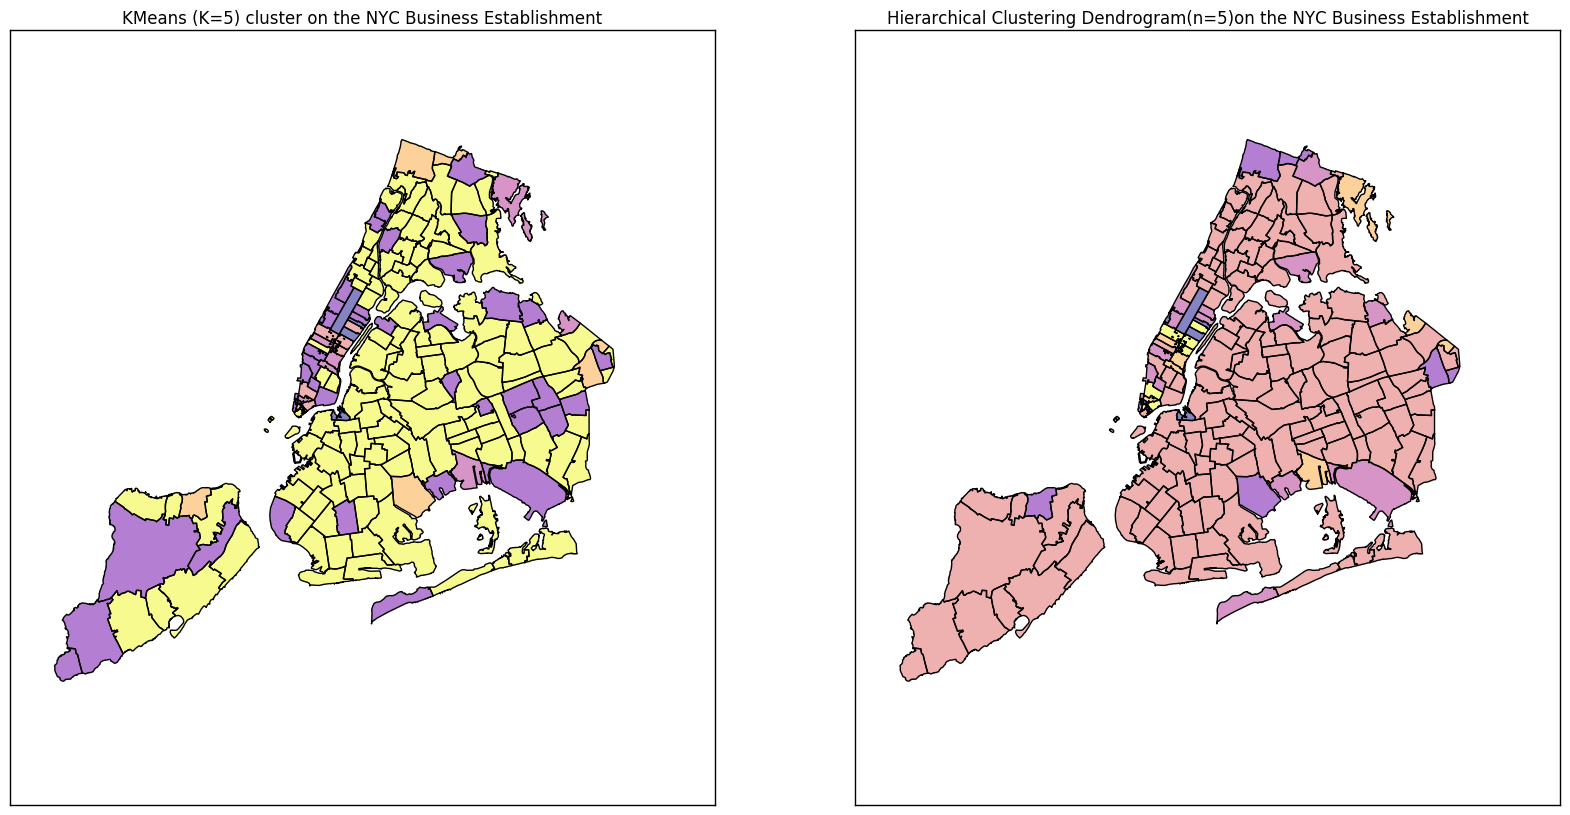

In [46]:
f, (ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
geonyc.plot(column="KM_5", cmap="plasma", categorical=True,ax=ax1)
ax1.set_title("KMeans (K=5) cluster on the NYC Business Establishment")
ax1.get_xaxis().set_visible(False)
ax1.get_yaxis().set_visible(False)
ax1.set_axis_bgcolor('white') 
geonyc.plot(column="HCD_5", cmap="plasma",categorical=True, ax=ax2)
ax2.set_title("Hierarchical Clustering Dendrogram(n=5)on the NYC Business Establishment")
ax2.get_xaxis().set_visible(False)
ax2.get_yaxis().set_visible(False)
ax2.set_axis_bgcolor('white') 

#### I think this map could explain more details as there are more clusters. Those two figs have certain differences, which may because of the way of caculation in the two methods. 

The central park is still as one cluster, and the 'purple areas' looks like 

you may need to clean your data: for some NYC zip codes there may be no info
    
sanity check: you should have 20 (N_timestamps) datapoints per time series and about 250 zipcodes (Nzipcodes)

IMPORTANT: we talked about the importance of "whitening" your data: dividing each feature by its standard deviation. 
Whitenings decorrelates the data: it makes the features independent so that the data covariance matrix is the identity matrix.
Whitening your data in time series analysis is in most cases **wrong**: you are modifying your time behaviour. This is because of the strong correlation between features (two consecutive time stamps for the same observation, the same zip code here, are strongly correlated). Here instead you want to standardize your time series: subtract the mean and divide each time series (separately) by its standard deviation. As a sanity check (if you use skitlearn Kmeans or skitlearns kmeans2): you want your data array to be shaped Nzipcodes x Ntimestamps

mydata.shape should be (Nzipcodes, Ntimestamps)

mydata[i].std() shoould be 1 for all i in range(len(Nzipcodes))

mydata[i].mean() should be ~0 for all i in range(len(Nzipcodes))



TASKS:
    
    1. get and prep your data.
    2. cluster the NUMBER OF ESTABLISHMENTS time series with K-means in **a few** clusters (as discussed there is no real good, sound way to decide what a good number is here. try a few options, keeping in mind a few is more than a couple, but i recommand you stay within the single digit numbers)
    3. plot the cluster centers (if you used K means those are the means of the clusters). you can plot for example the cluster centers overlayed on each time series (using the alpha channel to control the opacity in the plot may be helpful here).
    4. Use another clustering algorithm (of your choice)
    5. overlay your data on a NYC map: you can use shapefiles for the zip codes and different colors for different clusters
    6. Compare the results of the 2 algorithms
    7. attempt an interpretation. this is dangerous ground: clustering is an exploratory tool so you do not want to jump to conclusions because you see some clusters! but seeing structure in your data can inform your next moves as an investigator. 
    

The map of the clusters may look something like this

And if you use hierarchical clustering and make a dandrogram it may look like this`